# Predicting Life Satisfaction
## Author: Ahria Dominguez
### Last Updated: 6/30/2024

In this project, we use a dataset from Jong and colleagues (2020) on traumatic experiences and religiosity to see if life satisfaction can be predicted using the other features in the dataset. 

We run several different models on the data to determine the best-fitting model, including regressors and classifiers. This notebook only includes running the models and not all the data cleaning that was performed. That is in a separate notebook.

The data includes:

- COUNTRY: numeric code for the participant's country
- GENDER: numeric code for the participant's gender
- AGE: participant's age
- ABROAD: numeric code for if the participant has lived in another country
- ABROAD_YEAR: number of years the participant has lived in other countries
- MARITAL: numeric code for the participant's marital status
- EMPLOYMENT: numeric code for the participant's employment status
- INCOME: numeric code for the participant's income level (exact income not given in the de-identified data)
- LE1-LE29: individual Traumatic Life Events Index responses
- DASS1-DASS21: individual Depression Anxiety Stress Scales responses
- EX1-EX5: individual subjective Existential Security responses
- RELG_UP: question asking how religious the participant's upbringing was
- AFF_UP: the religious affiliation during the participant's upbringing
- RELG_NOW: question asking how religious the participant is now
- AFF_NOW: question asking about the religious affiliation of the participant now
- AFFILIATION: coded current religious affiliation
- SBS1-SBS6: individual Supernatural Belief Scale responses
- RELBEH1-RELBEH5: individual religious behavior responses
- LOCUS1-LOCUS6: individual Multidimensional Locus of Control Measure responses
- GOD1-GOD14: individual Views of God scale responses
- SWLS1-SWLS5: individual Satisfaction with Life Scale responses
- DAQ1-DAQ15: individual Death Anxiety Questionnaire responses
- JONG1-JONG12: individual Existential Death Anxiety Scale responses
- DROP1: if the participant passed/failed the first attention check
- CHECK: if the participant passed/failed all attention checks
- SBS: average score of the SBS
- EDAS: average score of the EDAS
- DAQ: average score of the DAQ
- LE_Sum: self-calculated Traumatic Life Events Index score
- DASS_Stress: self-calculated Stress score
- DASS_Anxiety: self-calculated Anxiety score
- DASS_Depression: self-calculated Depression score
- EX_Mean: self-calculated Existential Security score
- RELBEH_Mean: self-calculated religious behaviors score
- LOCUS_Mean: self-calculated Locus of Control score
- GOD_Pos: self-calculated Viewing God Positively score
- GOD_Neg: self-calculated Viewing God Negatively score
- SWLS_Mean: self-calculated Satisfaction with Life score

##### Import Libraries

In [1]:
# Imports the pandas library to load in and work with the data.
import pandas as pd

# Imports the necessary libraries to select features, model the data, 
# visualize elements, and evaluate the results.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
accuracy_score, classification_report, confusion_matrix, r2_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC

##### Import the Data

In [2]:
# Loads in the cleaned dataset into 'old_data'.
old_data = pd.read_csv("new_data.csv")

# Copies over the columns of interest into a new data frame (only getting rid 
# of individual questionnaire question scores, since I only need the full score).
data = old_data[['COUNTRY', 'GENDER', 'AGE', 'ABROAD', 'ABROAD_YEAR', 'MARITAL', 
                 'EMPLOYMENT', 'INCOME', 'SBS', 'EDAS', 'DAQ', 'LE_Sum', 
                 'DASS_Stress', 'DASS_Anxiety', 'DASS_Depression', 'EX_Mean', 
                 'RELBEH_Mean', 'LOCUS_Mean', 'GOD_Pos', 'GOD_Neg',
                 'SWLS_Mean']].copy()
print(data.head())

   COUNTRY  GENDER  AGE  ABROAD  ABROAD_YEAR  MARITAL  EMPLOYMENT  INCOME  \
0        2       2   35     1.0          2.0        3           1       8   
1        3       2   38     1.0          4.0        3           1       8   
2        2       2   46     1.0         11.0        1           1       5   
3        2       1   35     1.0          9.0        1           4       5   
4        2       1   50     1.0          3.0        3           3       5   

        SBS      EDAS  ...  LE_Sum  DASS_Stress  DASS_Anxiety  \
0  1.166667  1.666667  ...     2.0         15.0          13.0   
1  3.833333  2.333333  ...     6.0         13.0          17.0   
2  4.000000 -4.000000  ...     4.0          9.0           9.0   
3  0.666667 -4.000000  ...     5.0         14.0          13.0   
4  4.000000 -3.333333  ...    11.0         15.0          10.0   

   DASS_Depression  EX_Mean  RELBEH_Mean  LOCUS_Mean   GOD_Pos   GOD_Neg  \
0              9.0      4.2          5.4   -0.666667  4.000000 -2.8571

In [3]:
# Creates a copy of the new data frame for classifying models to use.
classifying_data = data.copy()

# Determines classes for people based on their satisfaction with life questionnaire
# score (SWLS).
def swls_cat(score):
    if -3 <= score < -1.5:
        return '4'
    elif -1.5 <= score < 0:
        return '3'
    elif 0 <= score < 1.5:
        return '2'
    elif 1.5 <= score <=3:
        return '1'
    else:
        return 'Unknown'
    
# Adds the classification to a new column in the copied data frame.
classifying_data['SWLS_Category'] = classifying_data['SWLS_Mean'].apply(swls_cat)

# Drops the 'SWLS_Mean' column since I only want the categorical data in the new,
# copied data frame.
classifying_data = classifying_data.drop(columns=['SWLS_Mean'])

##### Split the Data - Regressor Models

In [4]:
# Since there are two separate datasets - one for regressor models and one for
# classification models - I will split each dataset into train/test sets.

# Splits the data into features and target variables ('r' is for regressor).
X_r = data.drop(columns='SWLS_Mean')
y_r = data['SWLS_Mean']

# Splits the data into training and test sets with a random state of 42. 
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, 
                                                            test_size=0.25,
                                                           random_state=42)

##### Split the Data - Classification Models

In [5]:
# Splits the data into features and target variables ('c' is for classifier).
X_c = classifying_data.drop(columns='SWLS_Category')
y_c = classifying_data['SWLS_Category']

# Splits the data into training and test sets with a random state of 42. 
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, 
                                                            test_size=0.25,
                                                           random_state=42)

##### Feature Selection

However, I don't want the different models to have different features (making it hard to compare), so I will observe similarities in the results.

###### Regressor Models

Linear Regression

Optimal number of features : 6


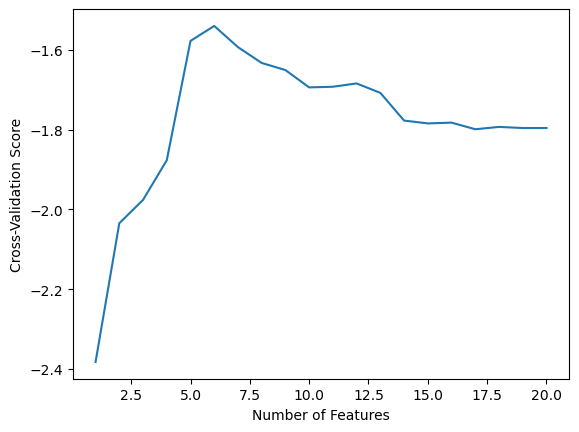

In [6]:
# Initializes the Linear Regression model.
lregress_model = LinearRegression()

# Assigns the necessary parameters for the recursive feature elimination with cross 
# validation (RFECV) for the linear regression. I will be using a cross-validation 
# parameter of 5 for all CVs. The score parameter of 'neg_mean_squared_error' is 
# common to use for linear regressions. 
lregress_rfecv  = RFECV(estimator=lregress_model, step=1, cv=5, 
                        scoring="neg_mean_squared_error") 

# Fits the RFECV to the training data.
lregress_rfecv.fit(X_train_r, y_train_r)

# Prints and plots the optimal amount of features for the linear regression RFECV.
print("Optimal number of features : %d" % lregress_rfecv.n_features_)
plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score")
plt.plot(range(1, len(lregress_rfecv.cv_results_["mean_test_score"]) + 1), 
         lregress_rfecv.cv_results_["mean_test_score"])
plt.show()

In [7]:
# Initializes the recursive feature elimination (RFE), defining the model (linear 
# regression) and the number of features to choose (found in the RFECV).
lregress_rfe = RFE(estimator=lregress_model, n_features_to_select=6)

# Fits the RFE to the regression data.
lregress_rfe.fit(X_train_r, y_train_r)

# Finds the best features and prints them out for later use. 
lregress_features = X_train_r.columns[lregress_rfe.support_]
print(lregress_features)

Index(['GENDER', 'MARITAL', 'INCOME', 'DASS_Depression', 'RELBEH_Mean',
       'GOD_Pos'],
      dtype='object')


Decision Tree Regressor

Optimal number of features : 1


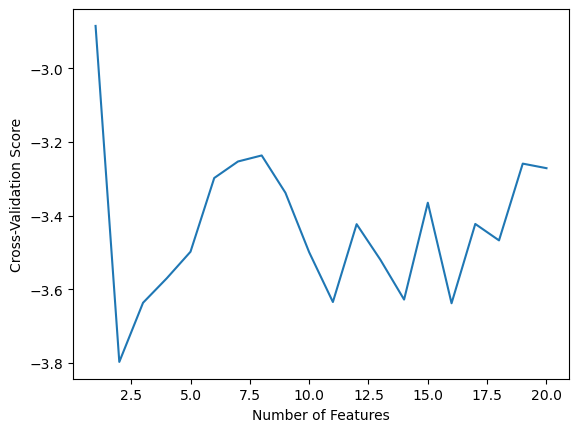

In [8]:
# Initializes the Decision Tree Regressor model. I included 'random_state=42'
# based on a StackOverflow article I found (cited below), and without it, it 
# said that the optimal number of features was 1. I figured that would be 
# overfitting the model.
dtr_model = DecisionTreeRegressor(random_state=42)

# Assigns the necessary parameters for the RFECV for the decision tree regressor.
dtr_rfecv  = RFECV(estimator=dtr_model, step=1, cv=5, scoring="neg_mean_squared_error") 

# Fits the RFECV to the training data.
dtr_rfecv.fit(X_train_r, y_train_r)

# Prints and plots the optimal amount of features for the decision tree regressor RFECV.
print("Optimal number of features : %d" % dtr_rfecv.n_features_)
plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score")
plt.plot(range(1, len(dtr_rfecv.cv_results_["mean_test_score"]) + 1), 
         dtr_rfecv.cv_results_["mean_test_score"])
plt.show()

In [9]:
# Initializes the RFE, defining the model (decision tree regressor), and the
# number of features to choose (found in the RFECV). 
dtr_rfe = RFE(estimator=dtr_model, n_features_to_select=20)

# Fits the RFE to the regression data.
dtr_rfe.fit(X_train_r, y_train_r)

# Finds the best features and prints them out for later use.
dtr_features = X_train_r.columns[dtr_rfe.support_]
print(dtr_features)

Index(['COUNTRY', 'GENDER', 'AGE', 'ABROAD', 'ABROAD_YEAR', 'MARITAL',
       'EMPLOYMENT', 'INCOME', 'SBS', 'EDAS', 'DAQ', 'LE_Sum', 'DASS_Stress',
       'DASS_Anxiety', 'DASS_Depression', 'EX_Mean', 'RELBEH_Mean',
       'LOCUS_Mean', 'GOD_Pos', 'GOD_Neg'],
      dtype='object')


Support Vector Regressor

Optimal number of features : 5


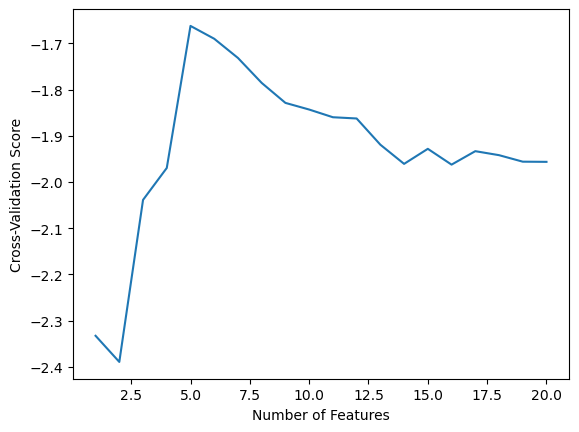

In [10]:
# Initializes the Support Vector Regressor model. I had to include a
# kernel parameter, otherwise the code would not work. 
svr_model = SVR(kernel='linear')

# Assigns the necessary parameters for the RFECV for the support vector regressor.
svr_rfecv  = RFECV(estimator=svr_model, step=1, cv=5, scoring="neg_mean_squared_error") 

# Fits the RFECV to the training data.
svr_rfecv.fit(X_train_r, y_train_r)

# Prints and plots the optimal amount of features for the support vector regressor 
# RFECV.
print("Optimal number of features : %d" % svr_rfecv.n_features_)
plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score")
plt.plot(range(1, len(svr_rfecv.cv_results_["mean_test_score"]) + 1), 
         svr_rfecv.cv_results_["mean_test_score"])
plt.show()

In [11]:
# Initializes the RFE, defining the model (support vector regressor), and the
# number of features to choose (found in the RFECV). 
svr_rfe = RFE(estimator=svr_model, n_features_to_select=5)

# Fits the RFE to the regression data.
svr_rfe.fit(X_train_r, y_train_r)

# Finds the best features and prints them out for later use.
svr_features = X_train_r.columns[svr_rfe.support_]
print(svr_features)

Index(['GENDER', 'MARITAL', 'DASS_Depression', 'RELBEH_Mean', 'GOD_Pos'], dtype='object')


###### Classifier Models

Decision Tree Classifier

Optimal number of features : 7


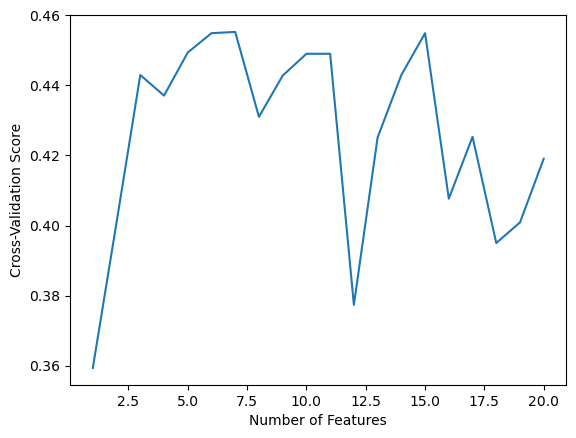

In [12]:
# Initializes the Decision Tree Classifier model. For the same reason as
# the decision tree regressor, I included 'random_state=42' (and to be consistent). 
dtc_model = DecisionTreeClassifier(random_state=42)

# Assigns the necessary parameters for the RFECV for the decision tree classifier.
dtc_rfecv = RFECV(estimator=dtc_model, step=1, cv=5, scoring="accuracy")

# Fits the RFECV to the training data.
dtc_rfecv.fit(X_train_c, y_train_c)

# Prints and plots the optimal amount of features for the decision tree classifier 
# RFECV.
print("Optimal number of features : %d" % dtc_rfecv.n_features_)
plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score")
plt.plot(range(1, len(dtc_rfecv.cv_results_["mean_test_score"]) + 1), 
         dtc_rfecv.cv_results_["mean_test_score"])
plt.show()

In [13]:
# Initializes the RFE, defining the model (decision tree classifier) and the
# number of features to choose (found in the RFECV).
dtc_rfe = RFE(estimator=dtc_model, n_features_to_select=7)

# Fits the RFE to the classifying data.
dtc_rfe.fit(X_train_c, y_train_c)

# Finds the best features and prints them out for later use.
dtc_features = X_train_c.columns[dtc_rfe.support_]
print(dtc_features)

Index(['AGE', 'SBS', 'EDAS', 'DASS_Anxiety', 'DASS_Depression', 'RELBEH_Mean',
       'GOD_Neg'],
      dtype='object')


Support Vector Classifier

Optimal number of features : 12


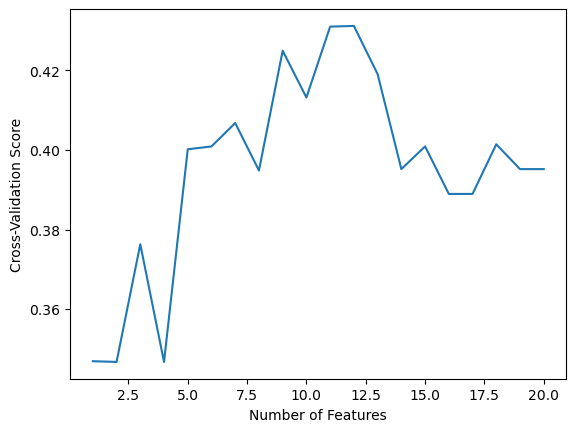

In [14]:
# Initializes the Support Vector Classifier model. Just like the SVR, I needed to
# specify the kernel to get it to work.
svc_model = SVC(kernel='linear')

# Assigns the necessary paramters for the RFECV for the support vector classifier. 
svc_rfecv = RFECV(estimator=svc_model, step=1, cv=5, scoring="accuracy")

# Fits the RFECV to the training data.
svc_rfecv.fit(X_train_c, y_train_c)

# Prints and plots the optimal amount of features for the support vector classifier 
# RFECV. 
print("Optimal number of features : %d" % svc_rfecv.n_features_)
plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score")
plt.plot(range(1, len(svc_rfecv.cv_results_["mean_test_score"]) + 1), 
         svc_rfecv.cv_results_["mean_test_score"])
plt.show()

In [15]:
# Initializes the RFE, defining the model (support vector classifier) and the
# number of features to choose (found in the RFECV). 
svc_rfe = RFE(estimator=svc_model, n_features_to_select=12)

# Fits the RFE to the classifier data.
svc_rfe.fit(X_train_c, y_train_c)

# Finds the best features and prints them out for later use.
svc_features = X_train_c.columns[svc_rfe.support_]
print(svc_features)

Index(['COUNTRY', 'GENDER', 'MARITAL', 'EMPLOYMENT', 'INCOME', 'DASS_Anxiety',
       'DASS_Depression', 'EX_Mean', 'RELBEH_Mean', 'LOCUS_Mean', 'GOD_Pos',
       'GOD_Neg'],
      dtype='object')


##### Selecting the Features

To select the features I will use for regression and classification models, I will select the common features within all the models (the feature has to be in AT LEAST two models for it to be included.

In [16]:
# Creates a variable that contains the names of columns of the selected features.
selected_features = ['COUNTRY', 'GENDER', 'MARITAL', 'AGE', 
                            'EMPLOYMENT', 'INCOME', 'SBS', 'EDAS', 
                            'DASS_Anxiety', 'DASS_Depression', 
                            'EX_Mean', 'RELBEH_Mean', 'GOD_Pos', 
                            'GOD_Neg', 'LOCUS_Mean']
# Creates new variables of feature data, or "X," with only the selected features for
# the regression models.
X_train_r_final = X_train_r[selected_features]
X_test_r_final = X_test_r[selected_features]

# Creates new variables of selected feature data for the classification models.
X_train_c_final = X_train_c[selected_features]
X_test_c_final = X_test_c[selected_features]

##### Grid Searches

No GridSearch is included in this notebook for the linear regression because the optimal parameters were the default parameters, so it was redundant. 

Decision Tree Regressor

In [17]:
# Defines the parameters to search through for the DTR GridSearchCV.
dtr_param_grid = {"splitter":["best", "random"],
                  "max_depth" : [1, 3, 5, 7, 9, 11, 12],
                  "min_samples_leaf":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  "max_leaf_nodes":[None, 10, 20, 30, 40, 50, 60, 70, 80, 90],
                  "max_features": [None, 5, 10, 15, 20]}

# Initializes the DTR GridSearchCV.
grid_search_dtr = GridSearchCV(estimator=dtr_model, param_grid=dtr_param_grid,
                              cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Performs the grid search on the selected training data.
grid_search_dtr.fit(X_train_r_final, y_train_r)

# Gets the best parameters for the DTR model.
best_dtr_params = grid_search_dtr.best_params_

# Finds the best DTR model and stores it into a variable (also printing
# it).
best_dtr_model = grid_search_dtr.best_estimator_
best_dtr_model

DecisionTreeRegressor(max_depth=5, max_features=10, min_samples_leaf=10,
                      random_state=42, splitter='random')

Support Vector Regressor

In [18]:
# Defines the parameters to search through for the SVR GridSearchCV.
svr_param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'C': [0.1, 1, 10, 100, 1000],
                  'gamma': ['scale', 'auto']}

# Initializes the SVR GridSearchCV. I also re-initialized the model estimator due 
# to the fact that I had to specify a kernel when finding the best features.
grid_search_svr = GridSearchCV(estimator=SVR(), param_grid=svr_param_grid,
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Performs the grid search on the selected training data.
grid_search_svr.fit(X_train_r_final, y_train_r)

# Gets the best parameters for the SVR model.
best_params_svr = grid_search_svr.best_params_

# Finds the best SVR model and stores it into a variable and prints it.
best_svr_model = grid_search_svr.best_estimator_
best_svr_model

SVR(C=1)

Decision Tree Classifier

In [19]:
# Defines the parameters to search through for the DTC GridSearchCV.
dtc_param_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': [None, 10, 20, 30],
                  'min_samples_split': [2, 5, 10],
                  'min_samples_leaf': [1, 2, 4],
                  'max_features': ['sqrt', 'log2', None,
                                  0.5, 1, 2, 3],
                  'class_weight': [None, 'balanced']}

# Initializes the DTC GridSearchCV.
grid_search_dtc = GridSearchCV(estimator=dtc_model, param_grid=dtc_param_grid,
                              cv=5, scoring='accuracy', n_jobs=-1)

# Performs the grid search on the selected training data.
grid_search_dtc.fit(X_train_c_final, y_train_c)

# Gets the best parameters for the DTC model.
best_params_dtc = grid_search_dtc.best_params_

# Finds the best DTC model and stores it into a variable and prints it. 
best_dtc_model = grid_search_dtc.best_estimator_
best_dtc_model

DecisionTreeClassifier(random_state=42)

Support Vector Classifier

In [20]:
# Defines the parameters to search through for the SVC GridSearchCV.
svc_param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'C': [0.1, 1, 10, 100, 1000]}

# Initializes the SVC GridSearchCV. I also re-initialized the model estimator due 
# to the fact that I had to specify a kernel when finding the best features.
grid_search_svc = GridSearchCV(estimator=SVC(), param_grid=svc_param_grid, cv=5,
                               scoring='accuracy', n_jobs=-1)

# Performs the grid search on the selected training data.
grid_search_svc.fit(X_train_c_final, y_train_c)

# Gets the best parameters for the SVC model.
best_params_svc = grid_search_svc.best_params_

# Finds the best SVC model and stores it into a variable and prints it.
best_svc_model = grid_search_svc.best_estimator_
best_svc_model

SVC(C=1000, gamma=0.0001)

##### Running the Models

Linear Regression

In [21]:
# Fits the linear regression model to the selected training features.
lregress_model.fit(X_train_r_final, y_train_r)

# Makes predictions on the testing data set.
lregress_preds = lregress_model.predict(X_test_r_final)

In [22]:
# Calculates evaluation metrics for the linear regression model.
l_r2_score = r2_score(y_test_r, lregress_preds)
l_rmse = np.sqrt(mean_squared_error(y_test_r, lregress_preds))
l_mae = mean_absolute_error(y_test_r, lregress_preds)

# Prints the results.
print("Linear Regression R2: {}".format(l_r2_score))
print("Linear Regression RMSE: {}".format(l_rmse))
print("Linear Regression MAE: {}".format(l_mae))

Linear Regression R2: 0.08946132704656728
Linear Regression RMSE: 1.200942572116858
Linear Regression MAE: 0.8941496092145156


OLS Regression

In [23]:
# Adds a constant intercept to the selected features in order to
# run an Ordinary Least Squares (OLS) regression model. 
ols_X_train = sm.add_constant(X_train_r_final)
ols_X_test = sm.add_constant(X_test_r_final)

In [24]:
# Fits the OLS regression model. 
ols_model = sm.OLS(y_train_r, ols_X_train).fit()

# Prints the summary of the regression model results.
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SWLS_Mean   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     8.197
Date:                Sat, 01 Jun 2024   Prob (F-statistic):           2.11e-13
Time:                        21:53:23   Log-Likelihood:                -260.37
No. Observations:                 167   AIC:                             552.7
Df Residuals:                     151   BIC:                             602.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7899      0.789      1.001      0.318      -0.769       2.349
COUNTRY            -0.0263      0.049     -0.541      0.589      -0.122       0.070
GENDER             -0.4765      0.194     -2.451      0.015      -0.861      -0.092
MARITAL             0.1201      0.088      1.363      0.175      -0.054       0.294
AGE                 0.0019      0.010      0.197      0.844      -0.017       0.021
EMPLOYMENT          0.0132      0.062      0.215      0.830      -0.109       0.135
INCOME              0.1737      0.063      2.768      0.006       0.050       0.298
SBS                 0.0356      0.072      0.492      0.623      -0.107       0.178
EDAS               -0.0214      0.040     -0.538      0.591      -0.100       0.057
DASS_Anxiety        0.0493      0.035      1.426      0.156      -0.019       0.118
DASS_Depression    -0.1434      0.029     -4.893      0.000      -0.201      -0.085
EX_Mean            -0.0406      0.133     -0.304      0.761      -0.304       0.223
RELBEH_Mean         0.1035      0.057      1.813      0.072      -0.009       0.216
GOD_Pos             0.0798      0.069      1.154      0.250      -0.057       0.216
GOD_Neg             0.0566      0.051      1.112      0.268      -0.044       0.157
LOCUS_Mean          0.0535      0.054      0.983      0.327      -0.054       0.161
==============================================================================
Omnibus:                        3.389   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.184   Jarque-Bera (JB):                2.819
Skew:                          -0.210   Prob(JB):                        0.244
Kurtosis:                       2.521   Cond. No.                         361.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Decision Tree Regressor

In [25]:
# Fits the DTR model using the best parameters and selected features.
best_dtr_model.fit(X_train_r_final, y_train_r)

# Calculates the predictions on the test data.
dtr_preds = best_dtr_model.predict(X_test_r_final)

In [26]:
# Calculates evaluation metrics for the decision tree regressor model.
dtr_r2_score = r2_score(y_test_r, dtr_preds)
dtr_rmse = np.sqrt(mean_squared_error(y_test_r, dtr_preds))
dtr_mae = mean_absolute_error(y_test_r, dtr_preds)

# Prints the results.
print("Decision Tree Regressor R2: {}".format(dtr_r2_score))
print("Decision Tree Regressor RMSE: {}".format(dtr_rmse))
print("Decision Tree Regressor MAE: {}".format(dtr_mae))

Decision Tree Regressor R2: 0.08825948426257735
Decision Tree Regressor RMSE: 1.2017348878331957
Decision Tree Regressor MAE: 0.9864633600095557


Support Vector Regressor

In [27]:
# Fits the SVR model using the best parameters and selected features.
best_svr_model.fit(X_train_r_final, y_train_r)

# Calculates the predictions on the test data.
svr_preds = best_svr_model.predict(X_test_r_final)

In [28]:
# Calculates the evaluation metrics for the support vector regressor model. 
svr_r2_score = r2_score(y_test_r, svr_preds)
svr_rmse = np.sqrt(mean_squared_error(y_test_r, svr_preds))
svr_mae = mean_absolute_error(y_test_r, svr_preds)

# Prints the results.
print("Support Vector Regressor R2: {}".format(svr_r2_score))
print("Support Vector Regressor RMSE: {}".format(svr_rmse))
print("Support Vector Regressor MAE: {}".format(svr_mae))

Support Vector Regressor R2: 0.0916832949356895
Support Vector Regressor RMSE: 1.199476359947955
Support Vector Regressor MAE: 0.9329215706678072


Decision Tree Classifier

In [29]:
# Fits the DTC model using the best parameters and selected features.
best_dtc_model.fit(X_train_c_final, y_train_c)

# Calculates the predictions on the test data.
dtc_preds = best_dtc_model.predict(X_test_c_final)

In [30]:
# Evaluates the DTC model via an accuracy score and a classification report.
dtc_accuracy = accuracy_score(y_test_c, dtc_preds)
dtc_classification = classification_report(y_test_c, dtc_preds)

# Prints the results.
print("Decision Tree Classifier Accuracy: {}".format(dtc_accuracy))
print("Decision Tree Classifier Classification Report:\n {}".format(dtc_classification))

Decision Tree Classifier Accuracy: 0.42857142857142855
Decision Tree Classifier Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.50      0.54        28
           2       0.47      0.50      0.49        18
           3       0.17      0.12      0.14         8
           4       0.00      0.00      0.00         2

    accuracy                           0.43        56
   macro avg       0.31      0.28      0.29        56
weighted avg       0.47      0.43      0.45        56



Support Vector Classifier

In [31]:
# Fits the SVC model using the best parameters and selected features.
best_svc_model.fit(X_train_c_final, y_train_c)

# Calculates the predictions based on the test data.
svc_preds = best_svc_model.predict(X_test_c_final)

In [32]:
# Evaluates the SVC model via an accuracy score and a classification report.
svc_accuracy = accuracy_score(y_test_c, svc_preds)
svc_classification = classification_report(y_test_c, svc_preds)

# Prints the results.
print("Support Vector Classifier Accuracy: {}".format(svc_accuracy))
print("Support Vector Classifier Classification Report:\n {}".format(svc_classification))

Support Vector Classifier Accuracy: 0.375
Support Vector Classifier Classification Report:
               precision    recall  f1-score   support

           1       0.53      0.57      0.55        28
           2       0.14      0.11      0.12        18
           3       0.33      0.25      0.29         8
           4       0.17      0.50      0.25         2

    accuracy                           0.38        56
   macro avg       0.29      0.36      0.30        56
weighted avg       0.37      0.38      0.37        56



##### References

- Jong, J. Baimel, A., Ross, R., McKay, R., Bluemke, M., & Halberstadt, J. (2020). Traumatic life experiences and religiosity in eight countires. _Scientific Data, 7_(140). https://doi.org/10.1038/s41597-020-0482-y

- https://stackoverflow.com/questions/47688734/recursive-feature-elimination-rfe-sklearn

- https://medium.com/@hsu.lihsiang.esth/feature-selection-with-recursive-feature-elimination-rfe-for-parisian-bike-count-data-23f0ce9db691

- https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html

- https://stats.stackexchange.com/questions/429962/recursive-feature-elimination-on-just-the-train-data-or-complete-dataset

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

- https://machinelearningmastery.com/rfe-feature-selection-in-python/

- https://stackoverflow.com/questions/76812504/attributeerror-rfecv-object-has-no-attribute-grid-scores

- https://www.kaggle.com/discussions/questions-and-answers/377391

- https://datascience.stackexchange.com/questions/21877/how-to-use-the-output-of-gridsearch